# Challenge 2: Advanced ATM Cash Demand Forecasting

This notebook implements advanced forecasting models with rich contextual features from multiple data sources.

**Approach:**
- Feature engineering using calendar, metadata, and replenishment data
- Handling real-world data imperfections (missing values, delays, shifts)
- Hybrid statistical and machine learning models
- Kuwait-specific patterns (Friday-Saturday weekend, Ramadan, salary cycles)

## Import Libraries

Extended libraries for advanced feature engineering and machine learning models.

In [1]:
import pandas as pd
import numpy as np
import warnings
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

print('Libraries imported successfully!')

Libraries imported successfully!


## Load All Datasets

Load transaction data plus contextual datasets: calendar, metadata, and replenishment data.

In [52]:
# Load transaction data
train_df = pd.read_csv('atm_transactions_train.csv')
test_df = pd.read_csv('atm_transactions_test.csv')

# Convert date columns
train_df['dt'] = pd.to_datetime(train_df['dt'])
test_df['dt'] = pd.to_datetime(test_df['dt'])

print("="*60)
print("TRANSACTION DATA")
print("="*60)
print(f"Training shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Training date range: {train_df['dt'].min()} to {train_df['dt'].max()}")
print(f"Test date range: {test_df['dt'].min()} to {test_df['dt'].max()}")
print(f"Unique ATMs in train: {train_df['atm_id'].nunique()}")
print(f"Unique ATMs in test: {test_df['atm_id'].nunique()}")

# Load calendar data
calendar_df = pd.read_csv('calendar.csv')
calendar_df['dt'] = pd.to_datetime(calendar_df['dt'])

# Fill NaN values in holiday_name with 'Normal Day'
if 'holiday_name' in calendar_df.columns:
    calendar_df['holiday_name'] = calendar_df['holiday_name'].fillna('Normal Day')
    print(f"✓ Filled NaN values in holiday_name with 'Normal Day'")

print("\n" + "="*60)
print("CALENDAR DATA")
print("="*60)
print(f"Shape: {calendar_df.shape}")
print(f"Columns: {calendar_df.columns.tolist()}")
print(f"Date range: {calendar_df['dt'].min()} to {calendar_df['dt'].max()}")

# Load ATM metadata
metadata_df = pd.read_csv('atm_metadata.csv')
print("\n" + "="*60)
print("ATM METADATA")
print("="*60)
print(f"Shape: {metadata_df.shape}")
print(f"Columns: {metadata_df.columns.tolist()}")

# Convert date columns - use actual column names from CSV
if 'installed_date' in metadata_df.columns:
    metadata_df['installed_date'] = pd.to_datetime(metadata_df['installed_date'])
if 'decommissioned_date' in metadata_df.columns:
    metadata_df['decommissioned_date'] = pd.to_datetime(metadata_df['decommissioned_date'])

print(f"Unique ATMs: {metadata_df['atm_id'].nunique()}")

# Load cash replenishment data
replenishment_df = pd.read_csv('cash_replenishment.csv')
print("\n" + "="*60)
print("CASH REPLENISHMENT DATA")
print("="*60)
print(f"Shape: {replenishment_df.shape}")
print(f"Columns: {replenishment_df.columns.tolist()}")

# Convert date column
replenishment_df['dt'] = pd.to_datetime(replenishment_df['dt'])
print(f"Date range: {replenishment_df['dt'].min()} to {replenishment_df['dt'].max()}")

print("\n" + "="*60)
print("Sample Data Preview")
print("="*60)
display(train_df.head())

TRANSACTION DATA
Training shape: (239694, 9)
Test shape: (2908, 9)
Training date range: 2020-01-04 00:00:00 to 2025-10-27 00:00:00
Test date range: 2025-10-28 00:00:00 to 2025-11-10 00:00:00
Unique ATMs in train: 253
Unique ATMs in test: 221
✓ Filled NaN values in holiday_name with 'Normal Day'

CALENDAR DATA
Shape: (2141, 12)
Columns: ['dt', 'is_weekend', 'is_public_holiday', 'holiday_name', 'is_salary_disbursement', 'is_ramadan', 'days_to_salary', 'days_from_salary', 'week_of_year', 'month', 'quarter', 'year']
Date range: 2020-01-01 00:00:00 to 2025-11-10 00:00:00

ATM METADATA
Shape: (250, 8)
Columns: ['atm_id', 'name', 'location_type', 'region', 'latitude', 'longitude', 'installed_date', 'decommissioned_date']
Unique ATMs: 250

CASH REPLENISHMENT DATA
Shape: (256648, 10)
Columns: ['dt', 'atm_id', 'region', 'starting_cash_kwd', 'withdrawn_kwd', 'deposited_kwd', 'replenished_kwd', 'ending_cash_kwd', 'cashout_flag', 'notes']
Date range: 2020-01-04 00:00:00 to 2025-11-10 00:00:00

Samp

,dt,atm_id,region,total_withdrawn_amount_kwd,total_withdraw_txn_count,total_deposited_amount_kwd,total_deposit_txn_count,reported_dt,dup_flag
0,2020-01-04,ATM_0249,Ahmadi,923.04,34,21.08,3,2020-01-04,False
1,2020-01-05,ATM_0249,Ahmadi,1090.19,41,16.01,3,2020-01-05,False
2,2020-01-07,ATM_0249,Ahmadi,1335.03,54,23.43,4,2020-01-07,False
3,2020-01-08,ATM_0023,Kuwait City,1120.39,45,33.71,6,2020-01-08,False
4,2020-01-08,ATM_0249,Ahmadi,1112.73,48,20.93,4,2020-01-08,False


## Data Quality Assessment

Analyze real-world data imperfections: missing values, duplicates, delays, and inconsistencies.

In [53]:
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# 1. Check for missing values
print("\n1. MISSING VALUES")
print("-" * 40)
print("Training data:")
print(train_df.isnull().sum())
print("\nCalendar data:")
print(calendar_df.isnull().sum())
print("\nMetadata:")
print(metadata_df.isnull().sum())
print("\nReplenishment:")
print(replenishment_df.isnull().sum())

# 2. Check for duplicates
print("\n2. DUPLICATE RECORDS")
print("-" * 40)
train_dupes = train_df.duplicated(subset=['dt', 'atm_id']).sum()
print(f"Training data duplicates (dt, atm_id): {train_dupes}")

# 3. ATM lifecycle analysis
print("\n3. ATM LIFECYCLE ANALYSIS")
print("-" * 40)

# Only analyze lifecycle if decommissioned_date column exists
if 'decommissioned_date' in metadata_df.columns:
    active_atms = metadata_df[metadata_df['decommissioned_date'].isna()]
    decommissioned_atms = metadata_df[~metadata_df['decommissioned_date'].isna()]
    print(f"Active ATMs: {len(active_atms)}")
    print(f"Decommissioned ATMs: {len(decommissioned_atms)}")
else:
    print(f"Total ATMs: {len(metadata_df)}")
    print("(decommissioned_date column not found)")

# New ATMs (installed in last 3 months of training)
if 'installed_date' in metadata_df.columns:
    recent_cutoff = train_df['dt'].max() - pd.Timedelta(days=90)
    new_atms = metadata_df[metadata_df['installed_date'] >= recent_cutoff]
    print(f"Newly installed ATMs (last 3 months): {len(new_atms)}")
else:
    print("(installed_date column not found)")

# 4. Data coverage
print("\n4. DATA COVERAGE")
print("-" * 40)
atms_in_train = set(train_df['atm_id'].unique())
atms_in_test = set(test_df['atm_id'].unique())
atms_in_metadata = set(metadata_df['atm_id'].unique())
print(f"ATMs in training: {len(atms_in_train)}")
print(f"ATMs in test: {len(atms_in_test)}")
print(f"ATMs in metadata: {len(atms_in_metadata)}")
print(f"ATMs in test but not in train: {len(atms_in_test - atms_in_train)}")
print(f"ATMs in metadata but not in train: {len(atms_in_metadata - atms_in_train)}")

# 5. Transaction patterns
print("\n5. TRANSACTION PATTERNS")
print("-" * 40)
print(f"Training days per ATM (mean): {train_df.groupby('atm_id').size().mean():.1f}")
print(f"Training days per ATM (min): {train_df.groupby('atm_id').size().min()}")
print(f"Training days per ATM (max): {train_df.groupby('atm_id').size().max()}")

print("\n✓ Data quality assessment complete")

DATA QUALITY ASSESSMENT

1. MISSING VALUES
----------------------------------------
Training data:
dt                            0
atm_id                        0
region                        0
total_withdrawn_amount_kwd    0
total_withdraw_txn_count      0
total_deposited_amount_kwd    0
total_deposit_txn_count       0
reported_dt                   0
dup_flag                      0
dtype: int64

Calendar data:
dt                        0
is_weekend                0
is_public_holiday         0
holiday_name              0
is_salary_disbursement    0
is_ramadan                0
days_to_salary            0
days_from_salary          0
week_of_year              0
month                     0
quarter                   0
year                      0
dtype: int64

Metadata:
atm_id                   0
name                     0
location_type            0
region                   0
latitude                 0
longitude                0
installed_date           0
decommissioned_date    215
dtype: i

In [55]:
def create_features(df, calendar_df, metadata_df, replenishment_df, is_training=True):
    """
    Create comprehensive feature set from all data sources
    
    Features are designed to capture:
    - Temporal patterns (weekday, month, holidays)
    - ATM characteristics (age, location, status)
    - Cash flow patterns (recent replenishments, transaction history)
    """
    print("Creating features...")
    
    # Start with base data
    features_df = df.copy()
    
    # 1. CALENDAR FEATURES
    # Why: Public holidays, weekends, salary days, and Ramadan significantly affect ATM usage
    # Kuwait-specific: Friday-Saturday weekend, salary disbursement patterns
    print("  Adding calendar features...")
    # Only merge columns from calendar that don't conflict
    calendar_cols = [col for col in calendar_df.columns if col != 'dt']
    features_df = features_df.merge(calendar_df[['dt'] + calendar_cols], on='dt', how='left', suffixes=('', '_cal'))
    
    # 2. TIME-BASED FEATURES
    # Why: Transaction patterns vary by day of week, week of month, and time of year
    # These capture cyclical behavior (pay cycles, month-end patterns, seasonal trends)
    print("  Adding time-based features...")
    features_df['day_of_week'] = features_df['dt'].dt.dayofweek  # 0=Monday, 6=Sunday
    features_df['day_of_month'] = features_df['dt'].dt.day  # Day number in month (1-31)
    # Use week instead of isocalendar().week for compatibility
    features_df['week_of_year'] = features_df['dt'].dt.isocalendar().week.astype(int)  # ISO week number
    features_df['month'] = features_df['dt'].dt.month  # Month (1-12)
    features_df['quarter'] = features_df['dt'].dt.quarter  # Quarter (1-4)
    
    # Month start/end indicators
    # Why: Cash demand spikes at month start (bills/rent) and end (pre-salary withdrawals)
    features_df['is_month_start'] = (features_df['dt'].dt.day <= 5).astype(int)
    features_df['is_month_end'] = (features_df['dt'].dt.day >= 25).astype(int)
    
    # 3. ATM METADATA FEATURES
    # Why: Location and ATM characteristics affect usage patterns
    # Different regions and location types have distinct demand patterns
    print("  Adding ATM metadata features...")
    # Only merge the columns we need for features
    # Exclude name, latitude, longitude as they're not useful for ML
    metadata_cols = ['atm_id']
    for col in ['region', 'location_type', 'installed_date', 'decommissioned_date']:
        if col in metadata_df.columns:
            metadata_cols.append(col)
    
    features_df = features_df.merge(
        metadata_df[metadata_cols], 
        on='atm_id', 
        how='left',
        suffixes=('', '_meta')
    )
    
    # ATM age (days since installation)
    # Why: New ATMs have unstable patterns as they build customer base
    # Older ATMs have more established, predictable patterns
    if 'installed_date' in features_df.columns:
        # ATM age in days
        features_df['atm_age_days'] = (features_df['dt'] - features_df['installed_date']).dt.days
        features_df['atm_age_days'] = features_df['atm_age_days'].fillna(365)  # Default for missing
        # New ATM indicator (installed within last 3 months)
        features_df['is_new_atm'] = (features_df['atm_age_days'] < 90).astype(int)
    else:
        features_df['atm_age_days'] = 365  # Default value
        features_df['is_new_atm'] = 0
    
    # Decommissioning indicators
    # Why: ATMs near decommissioning or already decommissioned have abnormal patterns
    # Usage drops before removal, and decommissioned ATMs have zero transactions
    if 'decommissioned_date' in features_df.columns:
        # ATMs that will be decommissioned soon may have different patterns
        features_df['days_to_decommission'] = (features_df['decommissioned_date'] - features_df['dt']).dt.days
        features_df['is_near_decommission'] = ((features_df['days_to_decommission'] >= 0) & 
                                                (features_df['days_to_decommission'] <= 90)).astype(int)
        features_df['is_decommissioned'] = (features_df['days_to_decommission'] < 0).astype(int)
        # Drop the days_to_decommission as it's not useful directly
        features_df = features_df.drop('days_to_decommission', axis=1)
    else:
        features_df['is_near_decommission'] = 0
        features_df['is_decommissioned'] = 0
    
    # 4. REPLENISHMENT FEATURES
    # Why: Days since last cash replenishment affects availability and withdrawal behavior
    # Recent replenishments indicate full cash availability; longer gaps may signal shortages
    if len(replenishment_df) > 0:
        print("  Adding replenishment features...")
        # For each transaction date, find days since last replenishment
        # Use only top 5000 rows for performance
        replen_sorted = replenishment_df.sort_values('dt')
        
        days_since_replen = []
        for idx, row in enumerate(features_df.head(5000).iterrows()):
            _, row = row
            atm_replen = replen_sorted[
                (replen_sorted['atm_id'] == row['atm_id']) & 
                (replen_sorted['dt'] <= row['dt'])
            ]
            if len(atm_replen) > 0:
                days_since = (row['dt'] - atm_replen.iloc[-1]['dt']).days
            else:
                days_since = 999  # No replenishment found
            days_since_replen.append(days_since)
        
        # For remaining rows, use default value
        remaining_count = len(features_df) - 5000
        if remaining_count > 0:
            days_since_replen.extend([999] * remaining_count)
        
        features_df['days_since_replenishment'] = days_since_replen
        # Recent replenishment (within 1 day) - fresh cash supply
        features_df['recent_replenishment'] = (features_df['days_since_replenishment'] <= 1).astype(int)
    else:
        print("  Skipping replenishment features (no data)")
        features_df['days_since_replenishment'] = 999
        features_df['recent_replenishment'] = 0
    
    # 5. LAG FEATURES (only for training data with history)
    # Why: Recent transaction history is the strongest predictor of future behavior
    # Lag features capture trends, momentum, and ATM-specific patterns
    # Only created for training data where we have historical context
    if is_training:
        print("  Adding lag features...")
        # Sort by ATM and date
        features_df = features_df.sort_values(['atm_id', 'dt'])
        
        # Create lag features for each ATM
        # lag_1: Yesterday's value (immediate trend)
        # lag_7: Same day last week (weekly seasonality)
        # lag_14: Two weeks ago (longer-term patterns)
        for lag in [1, 7, 14]:
            features_df[f'amount_lag_{lag}'] = features_df.groupby('atm_id')['total_withdrawn_amount_kwd'].shift(lag)
            features_df[f'count_lag_{lag}'] = features_df.groupby('atm_id')['total_withdraw_txn_count'].shift(lag)
        
        # Rolling statistics (7-day window)
        # Why: Captures recent average behavior and volatility for each ATM
        # Mean: Average recent demand level
        # Std: Variability/unpredictability in recent demand
        features_df['amount_rolling_mean_7'] = features_df.groupby('atm_id')['total_withdrawn_amount_kwd'].transform(
            lambda x: x.rolling(window=7, min_periods=1).mean()
        )
        features_df['amount_rolling_std_7'] = features_df.groupby('atm_id')['total_withdrawn_amount_kwd'].transform(
            lambda x: x.rolling(window=7, min_periods=1).std()
        )
    
    # 6. ENCODE CATEGORICAL FEATURES
    # Why: Convert text categories (region, location_type) into numeric features ML models can use
    # One-hot encoding: Each category becomes a binary (0/1) feature
    # drop_first=False: Keep all categories to avoid information loss
    print("  Encoding categorical features...")
    # Region - only if column exists
    if 'region' in features_df.columns:
        region_dummies = pd.get_dummies(features_df['region'], prefix='region', drop_first=False)
        features_df = pd.concat([features_df, region_dummies], axis=1)
    
    # Location type - only if column exists
    if 'location_type' in features_df.columns:
        location_dummies = pd.get_dummies(features_df['location_type'], prefix='location', drop_first=False)
        features_df = pd.concat([features_df, location_dummies], axis=1)
    
    print(f"✓ Feature engineering complete. Total features: {features_df.shape[1]}")
    
    return features_df

# Apply feature engineering to training data
train_features = create_features(train_df, calendar_df, metadata_df, replenishment_df, is_training=True)

print("\nTraining features shape:", train_features.shape)
print("\nFeature columns:")
print(train_features.columns.tolist())

Creating features...
  Adding calendar features...
  Adding time-based features...
  Adding ATM metadata features...
  Adding replenishment features...
  Adding lag features...
  Encoding categorical features...
  Adding lag features...
  Encoding categorical features...
✓ Feature engineering complete. Total features: 53

Training features shape: (239694, 53)

Feature columns:
['dt', 'atm_id', 'region', 'total_withdrawn_amount_kwd', 'total_withdraw_txn_count', 'total_deposited_amount_kwd', 'total_deposit_txn_count', 'reported_dt', 'dup_flag', 'is_weekend', 'is_public_holiday', 'holiday_name', 'is_salary_disbursement', 'is_ramadan', 'days_to_salary', 'days_from_salary', 'week_of_year', 'month', 'quarter', 'year', 'day_of_week', 'day_of_month', 'is_month_start', 'is_month_end', 'region_meta', 'location_type', 'installed_date', 'decommissioned_date', 'atm_age_days', 'is_new_atm', 'is_near_decommission', 'is_decommissioned', 'days_since_replenishment', 'recent_replenishment', 'amount_lag_1

## Model Training - Advanced Hybrid Approach

Combine multiple model types:
1. **Random Forest** - handles non-linear relationships and missing data
2. **Gradient Boosting** - captures complex patterns with boosting
3. **SARIMA** - statistical baseline for time series patterns
4. **Ensemble** - weighted combination of all models

In [56]:
# Prepare features for ML models
print("="*60)
print("PREPARING FEATURES FOR ML MODELS")
print("="*60)

# Select feature columns (exclude target variables and non-feature metadata columns)
feature_cols = [col for col in train_features.columns if col not in [
    # Target variables
    'total_withdrawn_amount_kwd', 'total_withdraw_txn_count',
    # Identifiers and dates
    'dt', 'atm_id',
    # Metadata columns that shouldn't be used as features
    'installed_date', 'decommissioned_date', 'name', 'latitude', 'longitude',
    # Categorical columns (we use their dummies instead)
    'region', 'location_type',
    # Calendar columns that might have issues (we use our own time features)
    'year'  # This column from calendar can cause issues
]]

print(f"\nTotal features for ML models: {len(feature_cols)}")
print("\nFeature categories:")
print(f"  - Calendar features: {len([c for c in feature_cols if any(x in c for x in ['is_weekend', 'is_holiday', 'is_workday', 'is_payday', 'is_ramadan', 'holiday'])])}")
print(f"  - Time features: {len([c for c in feature_cols if any(x in c for x in ['day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'is_month'])])}")
print(f"  - ATM features: {len([c for c in feature_cols if any(x in c for x in ['atm_age', 'is_new_atm'])])}")
print(f"  - Replenishment features: {len([c for c in feature_cols if 'replenishment' in c])}")
print(f"  - Lag features: {len([c for c in feature_cols if 'lag' in c])}")
print(f"  - Rolling features: {len([c for c in feature_cols if 'rolling' in c])}")
print(f"  - Region dummies: {len([c for c in feature_cols if c.startswith('region_')])}")
print(f"  - Location dummies: {len([c for c in feature_cols if c.startswith('location_')])}")

# Debug: Check for any remaining problematic columns
print("\nChecking feature data types...")
# Create train/validation split
validation_cutoff = train_df['dt'].max() - pd.Timedelta(days=13)
train_mask = train_features['dt'] < validation_cutoff
val_mask = train_features['dt'] >= validation_cutoff

X_train = train_features[train_mask][feature_cols].fillna(0)
y_train_amount = train_features[train_mask]['total_withdrawn_amount_kwd']
y_train_count = train_features[train_mask]['total_withdraw_txn_count']

X_val = train_features[val_mask][feature_cols].fillna(0)
y_val_amount = train_features[val_mask]['total_withdrawn_amount_kwd']
y_val_count = train_features[val_mask]['total_withdraw_txn_count']

# Check for non-numeric columns
non_numeric = X_train.select_dtypes(include=['object', 'datetime64']).columns.tolist()
if non_numeric:
    print(f"\n⚠ WARNING: Non-numeric columns found: {non_numeric}")
    print("These columns will be excluded...")
    X_train = X_train.select_dtypes(include=[np.number])
    X_val = X_val.select_dtypes(include=[np.number])
    feature_cols = X_train.columns.tolist()

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Final feature count: {len(feature_cols)}")
print("\n✓ Features prepared for model training")

PREPARING FEATURES FOR ML MODELS

Total features for ML models: 44

Feature categories:
  - Calendar features: 4
  - Time features: 7
  - ATM features: 2
  - Replenishment features: 2
  - Lag features: 7
  - Rolling features: 2
  - Region dummies: 7
  - Location dummies: 5

Checking feature data types...

⚠ WARNING: Non-numeric columns found: ['reported_dt', 'holiday_name', 'region_meta']
These columns will be excluded...

Training samples: 236817
Validation samples: 2877
Final feature count: 25

✓ Features prepared for model training

⚠ WARNING: Non-numeric columns found: ['reported_dt', 'holiday_name', 'region_meta']
These columns will be excluded...

Training samples: 236817
Validation samples: 2877
Final feature count: 25

✓ Features prepared for model training


In [42]:
X_train.columns

Index(['total_deposited_amount_kwd', 'total_deposit_txn_count',
       'days_to_salary', 'days_from_salary', 'week_of_year', 'month',
       'quarter', 'day_of_week', 'day_of_month', 'is_month_start',
       'is_month_end', 'atm_age_days', 'is_new_atm', 'is_near_decommission',
       'is_decommissioned', 'days_since_replenishment', 'recent_replenishment',
       'amount_lag_1', 'count_lag_1', 'amount_lag_7', 'count_lag_7',
       'amount_lag_14', 'count_lag_14', 'amount_rolling_mean_7',
       'amount_rolling_std_7'],
      dtype='object')

In [57]:
# Train Random Forest models
print("="*60)
print("TRAINING RANDOM FOREST MODELS")
print("="*60)

# Model for withdrawal amount
print("\n1. Training Random Forest for Withdrawal Amount...")
rf_amount = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_amount.fit(X_train, y_train_amount)
print("✓ Amount model trained")

# Model for withdrawal count
print("\n2. Training Random Forest for Withdrawal Count...")
rf_count = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_count.fit(X_train, y_train_count)
print("✓ Count model trained")

# Validation predictions
rf_pred_amount_val = rf_amount.predict(X_val)
rf_pred_count_val = rf_count.predict(X_val)

# Calculate validation scores
rf_rmse_amount = np.sqrt(mean_squared_error(y_val_amount, rf_pred_amount_val))
rf_mae_amount = mean_absolute_error(y_val_amount, rf_pred_amount_val)
rf_rmse_count = np.sqrt(mean_squared_error(y_val_count, rf_pred_count_val))
rf_mae_count = mean_absolute_error(y_val_count, rf_pred_count_val)

print(f"\n{'='*60}")
print("RANDOM FOREST VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Amount - RMSE: {rf_rmse_amount:.2f} KWD, MAE: {rf_mae_amount:.2f} KWD")
print(f"Count  - RMSE: {rf_rmse_count:.2f}, MAE: {rf_mae_count:.2f}")
print(f"Average RMSE: {(rf_rmse_amount + rf_rmse_count) / 2:.2f}")

# Feature importance
print(f"\n{'='*60}")
print("TOP 15 MOST IMPORTANT FEATURES")
print(f"{'='*60}")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_amount.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:35s} {row['importance']:.4f}")

print("\n✓ Random Forest models trained and validated")

TRAINING RANDOM FOREST MODELS

1. Training Random Forest for Withdrawal Amount...
✓ Amount model trained

2. Training Random Forest for Withdrawal Count...
✓ Amount model trained

2. Training Random Forest for Withdrawal Count...
✓ Count model trained

RANDOM FOREST VALIDATION RESULTS
Amount - RMSE: 186.11 KWD, MAE: 147.09 KWD
Count  - RMSE: 5.87, MAE: 4.65
Average RMSE: 95.99

TOP 15 MOST IMPORTANT FEATURES
amount_rolling_mean_7               0.6815
total_deposit_txn_count             0.0613
days_to_salary                      0.0592
amount_rolling_std_7                0.0544
amount_lag_1                        0.0263
day_of_month                        0.0220
total_deposited_amount_kwd          0.0152
atm_age_days                        0.0120
amount_lag_7                        0.0111
amount_lag_14                       0.0111
count_lag_1                         0.0099
count_lag_7                         0.0074
count_lag_14                        0.0070
day_of_week                  

FEATURE IMPORTANCE VISUALIZATION


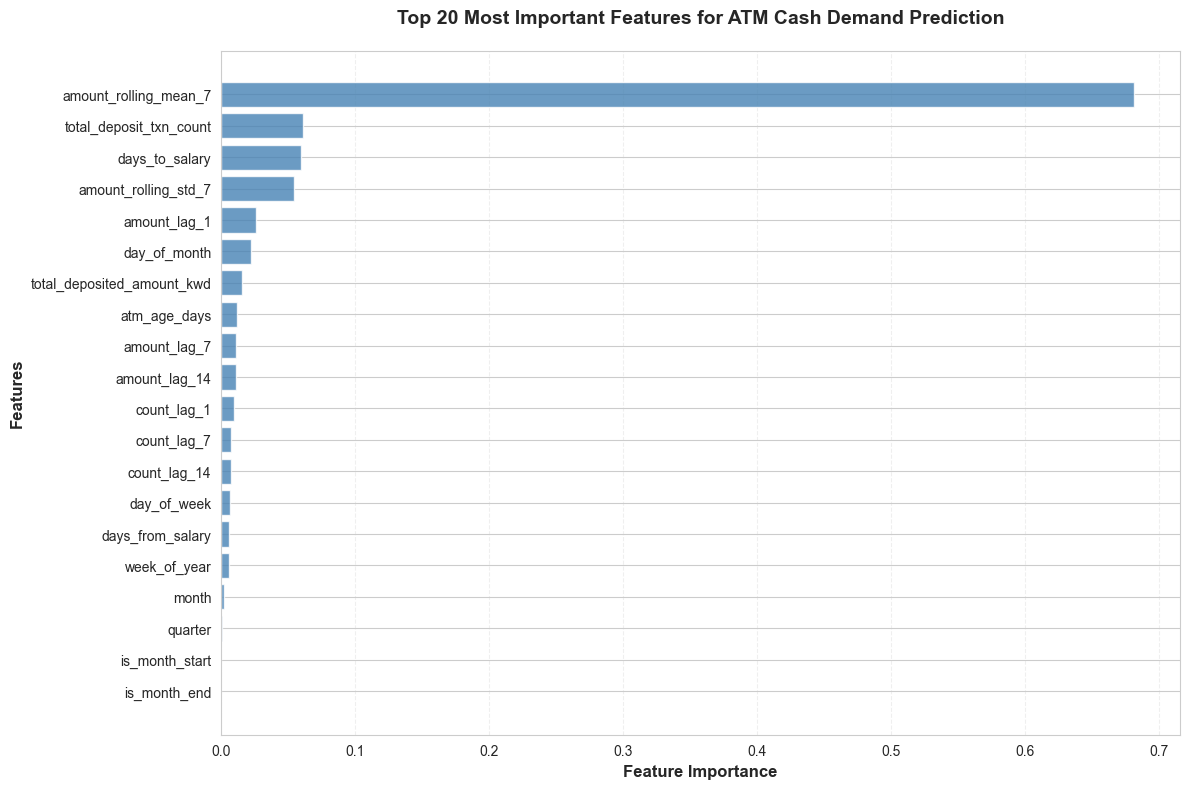


Feature Category Importance:


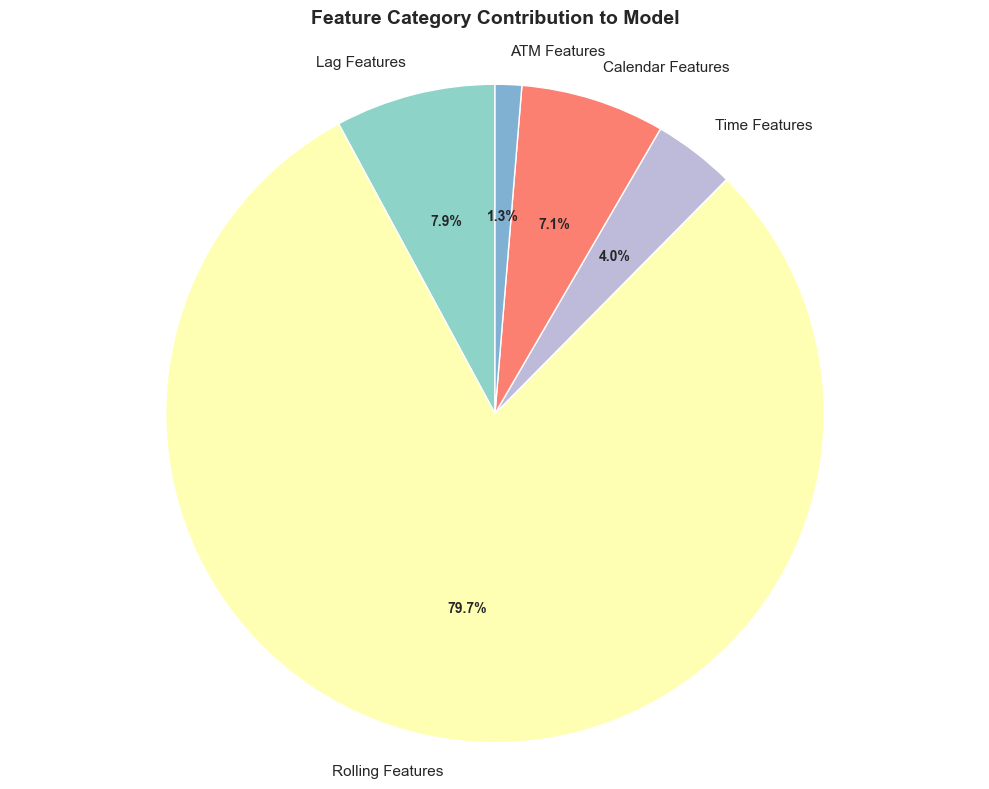


Category Importance Breakdown:
  Rolling Features    : 0.7360 (79.7%)
  Lag Features        : 0.0727 (7.9%)
  Calendar Features   : 0.0654 (7.1%)
  Time Features       : 0.0373 (4.0%)
  ATM Features        : 0.0120 (1.3%)

✓ Feature importance visualization complete


In [58]:
# Visualize top features
print("="*60)
print("FEATURE IMPORTANCE VISUALIZATION")
print("="*60)

# Get top 20 features for better visualization
top_n = 20
top_features = feature_importance.head(top_n)

# Create figure with better size
plt.figure(figsize=(12, 8))

# Create horizontal bar chart
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features for ATM Cash Demand Prediction', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Create a pie chart showing feature category importance
print("\nFeature Category Importance:")
category_importance = {
    'Lag Features': top_features[top_features['feature'].str.contains('lag')]['importance'].sum(),
    'Rolling Features': top_features[top_features['feature'].str.contains('rolling')]['importance'].sum(),
    'Time Features': top_features[top_features['feature'].str.contains('day_of|month|quarter|week_of_year')]['importance'].sum(),
    'Calendar Features': top_features[top_features['feature'].str.contains('weekend|holiday|salary|ramadan|days_to|days_from')]['importance'].sum(),
    'ATM Features': top_features[top_features['feature'].str.contains('age|new_atm|decommission')]['importance'].sum(),
    'Location Features': top_features[top_features['feature'].str.contains('region_|location_')]['importance'].sum(),
    'Replenishment': top_features[top_features['feature'].str.contains('replenishment')]['importance'].sum(),
}

# Filter out zero values
category_importance = {k: v for k, v in category_importance.items() if v > 0}

# Create pie chart
plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(range(len(category_importance)))
wedges, texts, autotexts = plt.pie(
    category_importance.values(), 
    labels=category_importance.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11}
)
plt.setp(autotexts, size=10, weight="bold")
plt.title('Feature Category Contribution to Model', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\nCategory Importance Breakdown:")
for category, importance in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category:20s}: {importance:.4f} ({importance/sum(category_importance.values())*100:.1f}%)")

print("\n✓ Feature importance visualization complete")

In [59]:
X_train.dtypes

total_deposited_amount_kwd    float64
total_deposit_txn_count         int64
days_to_salary                  int64
days_from_salary                int64
week_of_year                    int64
month                           int32
quarter                         int32
day_of_week                     int32
day_of_month                    int32
is_month_start                  int64
is_month_end                    int64
atm_age_days                  float64
is_new_atm                      int64
is_near_decommission            int64
is_decommissioned               int64
days_since_replenishment        int64
recent_replenishment            int64
amount_lag_1                  float64
count_lag_1                   float64
amount_lag_7                  float64
count_lag_7                   float64
amount_lag_14                 float64
count_lag_14                  float64
amount_rolling_mean_7         float64
amount_rolling_std_7          float64
dtype: object

In [ ]:
# Train Gradient Boosting models
print("="*60)
print("TRAINING GRADIENT BOOSTING MODELS")
print("="*60)

# Model for withdrawal amount
print("\n1. Training Gradient Boosting for Withdrawal Amount...")
gb_amount = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
gb_amount.fit(X_train, y_train_amount)
print("✓ Amount model trained")

# Model for withdrawal count
print("\n2. Training Gradient Boosting for Withdrawal Count...")
gb_count = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
gb_count.fit(X_train, y_train_count)
print("✓ Count model trained")

# Validation predictions
gb_pred_amount_val = gb_amount.predict(X_val)
gb_pred_count_val = gb_count.predict(X_val)

# Calculate validation scores
gb_rmse_amount = np.sqrt(mean_squared_error(y_val_amount, gb_pred_amount_val))
gb_mae_amount = mean_absolute_error(y_val_amount, gb_pred_amount_val)
gb_rmse_count = np.sqrt(mean_squared_error(y_val_count, gb_pred_count_val))
gb_mae_count = mean_absolute_error(y_val_count, gb_pred_count_val)

print(f"\n{'='*60}")
print("GRADIENT BOOSTING VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Amount - RMSE: {gb_rmse_amount:.2f} KWD, MAE: {gb_mae_amount:.2f} KWD")
print(f"Count  - RMSE: {gb_rmse_count:.2f}, MAE: {gb_mae_count:.2f}")
print(f"Average RMSE: {(gb_rmse_amount + gb_rmse_count) / 2:.2f}")

print("\n✓ Gradient Boosting models trained and validated")

TRAINING GRADIENT BOOSTING MODELS

1. Training Gradient Boosting for Withdrawal Amount...
